## Creating Route Data with county locations and FIPS codes
This script will create a file that joins the route data with county shapefile data to pinpoint the US state and county that each route took place in, which makes it potentially more easily joined with environmental data with FIPS codes. The code will output and save a csv file called "Routes_with_FIPS.csv" in the Data folder. Note that all points which lie outside US counties (including all Canadian data) has its state and fips codes saved as "None".

Note that you may need to install some of the non-standard libraries below; cartopy, geopandas, shapely

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import os
import geopandas as gpd
from shapely.geometry import Point

In [8]:
# Load CSV data into a DataFrame
current_dir = os.getcwd()
csv_file = os.path.join(current_dir, '..', 'Data', 'routes.csv')
df = pd.read_csv(csv_file, encoding='latin-1')

df.head()

,CountryNum,StateNum,Route,RouteName,Active,Latitude,Longitude,Stratum,BCR,RouteTypeID,RouteTypeDetailID
0,840,2,1,ST FLORIAN,1,34.868688,-87.604142,14,27,1,1
1,840,2,2,HILLSBORO,0,34.638675,-87.191292,14,24,1,1
2,840,2,3,FLORENCE,0,34.800000,-87.733333,14,24,1,1
3,840,2,4,TRADE,1,34.029788,-87.059235,13,28,1,1
4,840,2,5,SUMMITT,0,34.201669,-86.493409,13,28,1,1


In [9]:
coordinates = df[["Latitude", "Longitude"]].copy()

coordinates.head()

,Latitude,Longitude
0,34.868688,-87.604142
1,34.638675,-87.191292
2,34.800000,-87.733333
3,34.029788,-87.059235
4,34.201669,-86.493409


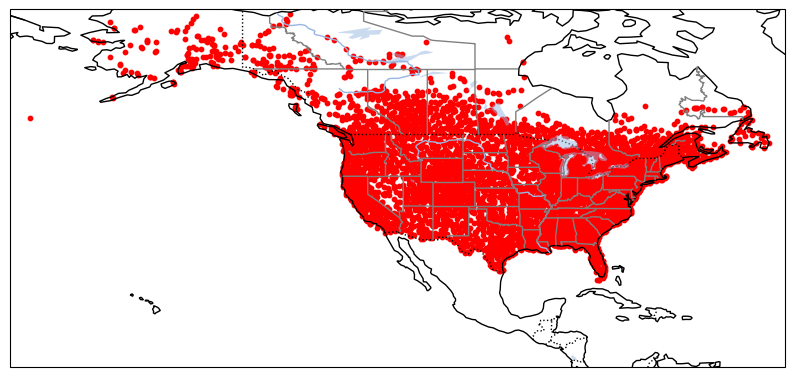

In [10]:
# Create a plot and set the map projection
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-180, -50, 10, 70], crs=ccrs.PlateCarree())

states_provinces = cartopy.feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

# Add map features
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(states_provinces, edgecolor='gray')

# Plot the points
ax.scatter(coordinates['Longitude'], coordinates['Latitude'], color='red', s=10, transform=ccrs.PlateCarree())

# Show the plot
plt.show()

In [11]:
counties = gpd.read_file(os.path.join(current_dir, '..', 'SharedData', 'UScounties', 'UScounties.shp'))

df[["StateName","CountyName","StateFIPS","CountyFIPS"]] = None
state_names = []
state_codes = []
county_names = []
county_codes = []
for i, row in coordinates.iterrows():
    point = Point(row["Longitude"], row["Latitude"])
    # Spatial query to find the county containing the point
    county = counties[counties.contains(point)]

    # Print the county name
    if not county.empty:
        county_name = county.iloc[0]['NAME']
        state_name = county.iloc[0]['STATE_NAME']
        county_fips = county.iloc[0]['CNTY_FIPS']
        state_fips = county.iloc[0]['STATE_FIPS']
        state_names.append(state_name)
        county_names.append(county_name)
        state_codes.append(state_fips)
        county_codes.append(county_fips)
    else:
        state_names.append(None)
        county_names.append(None)
        state_codes.append(None)
        county_codes.append(None)
        
df["StateName"] = state_names
df["CountyName"] = county_names
df["StateFIPS"] = state_codes
df["CountyFIPS"] = county_codes

df.to_csv(os.path.join(current_dir, '..', 'Data', 'Routes_with_FIPS.csv'), index=False)

# Optionally, you can visualize the result
# ax = counties.plot(figsize=(10, 10), color='white', edgecolor='black')
# gpd.GeoSeries([point]).plot(ax=ax, marker='o', color='red', markersize=100)
# plt.show()

In [12]:
df.head()

,CountryNum,StateNum,Route,RouteName,Active,Latitude,Longitude,Stratum,BCR,RouteTypeID,RouteTypeDetailID,StateName,CountyName,StateFIPS,CountyFIPS
0,840,2,1,ST FLORIAN,1,34.868688,-87.604142,14,27,1,1,Alabama,Lauderdale,01,077
1,840,2,2,HILLSBORO,0,34.638675,-87.191292,14,24,1,1,Alabama,Lawrence,01,079
2,840,2,3,FLORENCE,0,34.800000,-87.733333,14,24,1,1,Alabama,Lauderdale,01,077
3,840,2,4,TRADE,1,34.029788,-87.059235,13,28,1,1,Alabama,Cullman,01,043
4,840,2,5,SUMMITT,0,34.201669,-86.493409,13,28,1,1,Alabama,Blount,01,009
